# SKEMA-TA2-UAZ Demo (2022-12-08)

**Authors**: Justin Lieffers, Liang Zhang, Deepsana Shahi, Adarsh Pyarelal, Clayton Morrison

The overall goals of the SKEMA-TA2-UAZ effort are:
- Automate the identification of model roles in code.
- Perform structural alignment to link equations to code.

In this notebook, we demonstrate functionality we have developed so far via a REST API, which should facilitate integration with other ASKEM performer teams.

Swagger docs for the REST API can be found at http://localhost:8080/api-docs/ (if you are running locally).

## Model role identification

One of the prerequisites for model role identification is the ability to efficiently query GroMEts, including path traversal queries. For this reason, we have adopted a graph database backend for storing the structure inherent in GroMEt JSON files, along with additional metadata to speed up queries.

Below, we demonstrate how to interact with this database using our REST API.

First, we perform our imports and set the base URL

In [3]:
import json
from requests import get, put, post, delete
from graphviz import Source
BASE_URL="http://localhost:8080"

Then, we check if the service is running.

In [ ]:
get(f"{BASE_URL}/ping").text

We then insert the model represented by the GroMEt JSON file `CHIME_SVIIvR_core--Gromet-FN-auto.json` into the database. The operation returns the ID of the model that was just inserted - we will use this ID to query the model later.

In [ ]:
with open('../../../data/demo/CHIME_SVIIvR_core--Gromet-FN-auto.json') as f:
    r = post(f"{BASE_URL}/models", json=json.load(f))
    MODEL_ID = r.json()
    print(f"Model ID: {MODEL_ID}")

We then get the IDs of all the models in the database to double check if our model ID is among them.

In [ ]:
get(f"{BASE_URL}/models").json()

Next, we run a query to get all the names of named `opo`s in the model we just added to the database.

In [ ]:
get(f"{BASE_URL}/models/{MODEL_ID}/named_opos").json()

Similarly, we run a query to get all the names of named `opi`s in the model.

In [ ]:
get(f"{BASE_URL}/models/{MODEL_ID}/named_opis").json()

Finally, we demonstrate the API endpoint for deleting a model.

In [ ]:
delete(f"{BASE_URL}/models/{MODEL_ID}").text

Get the IDs of all the models in the database again to check that the model has been deleted.

In [ ]:
get(f"{BASE_URL}/models").json()

## Incremental structural alignment

**A quick review**: We proposed using a seeded graph matching (SGM) to achieve incremental structural alignment (ISA) of formulas in documents and formulas in source codes. The procedure of this alignment is presented as follows:

- First, it is necessary to create a corresponding graph based on the connection relationship between the variables in the formula (connected by mathematical operators). 
- Then, the adjacency matrix corresponding to the graph is generated. 
- Finally, the SGM method is performed based on the two adjacency matrices generated by the two formulas in order to achieve the variable alignment task.

Therefore, prior to performing the alignment task, it is necessary to generate a graph representation of formulas. 

$S_{t+1} = S_t - \beta S_t I_t $

In [7]:
content = \
"""<math 
    xmlns="http://www.w3.org/1998/Math/MathML" 
    display="block" 
    title="S_{t+1} = S_t - \beta S_t I_t "
>
  <mrow>
    <msub>
      <mrow>
        <mi>S</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
        <mo>+</mo>
        <mn>1</mn>
      </mrow>
    </msub>
    <mo>=</mo>
    <msub>
      <mrow>
        <mi>S</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
      </mrow>
    </msub>
    <mo>-</mo>
    <mi>β</mi>
    <msub>
      <mrow>
        <mi>S</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
      </mrow>
    </msub>
    <msub>
      <mrow>
        <mi>I</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
      </mrow>
    </msub>
  </mrow>
</math>"""

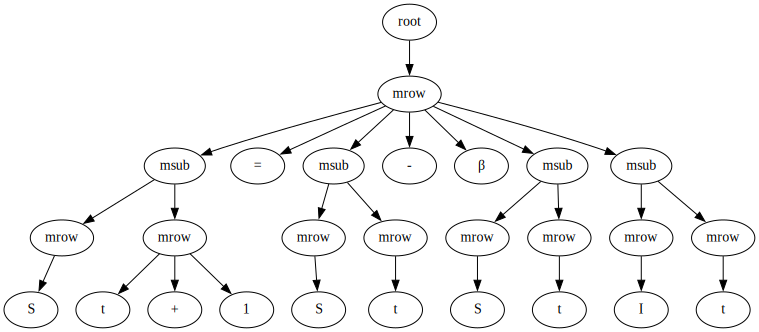

In [8]:
Source(
    put('http://localhost:8080/mathml/ast-graph',
        data=content.encode('utf-8')).text
)

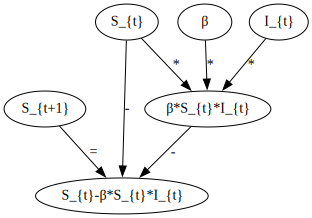

In [9]:
Source(
    put(
        'http://localhost:8080/mathml/math-exp-graph',
        data=content.encode('utf-8')).text
)